# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import shutil
import random
import gdown
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import files
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image


In [ ]:
url = 'https://drive.google.com/uc?id=1vt8A5IPheadrNI2i4WH8R_NXA6lfB2nn'
output = 'Waste-dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1vt8A5IPheadrNI2i4WH8R_NXA6lfB2nn
From (redirected): https://drive.google.com/uc?id=1vt8A5IPheadrNI2i4WH8R_NXA6lfB2nn&confirm=t&uuid=af30e1d9-1271-45b9-8805-4e8687a024f6
To: /content/Waste-dataset.zip
100%|██████████| 375M/375M [00:06<00:00, 55.4MB/s]


'Waste-dataset.zip'

In [ ]:
# Unzip dataset
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('waste_dataset')

In [ ]:
# 4. Define path setelah unzip
images_path = 'waste_dataset/images'   # Folder semua gambar
labels_path = 'waste_dataset/labels'   # Folder semua label YOLO
yaml_path = 'waste_dataset/data.yaml'  # Lokasi file data.yaml
output_path = 'waste_dataset/sorted_images'  # Folder output (gambar terpisah per kelas)

In [ ]:
# 5. Baca file data.yaml untuk mapping kelas
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']
print("Daftar kelas yang ditemukan:", class_names)

# 6. Buat folder untuk masing-masing kelas
for name in class_names:
    class_folder = os.path.join(output_path, name)
    os.makedirs(class_folder, exist_ok=True)

print("Folder untuk masing-masing kelas sudah dibuat.")

Daftar kelas yang ditemukan: ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']
Folder untuk masing-masing kelas sudah dibuat.


In [ ]:
# 7. Proses label.txt untuk memindahkan gambar
for label_file in os.listdir(labels_path):
    if label_file.endswith('.txt'):
        label_path = os.path.join(labels_path, label_file)

        with open(label_path, 'r') as f:
            lines = f.readlines()

        if lines:  # Jika file label tidak kosong
            first_line = lines[0].strip()
            class_idx = int(first_line.split()[0])  # Ambil index kelas dari baris pertama
            class_name = class_names[class_idx]

            # Tentukan nama file gambar
            img_filename_jpg = label_file.replace('.txt', '.jpg')
            img_filename_png = label_file.replace('.txt', '.png')

            img_path_jpg = os.path.join(images_path, img_filename_jpg)
            img_path_png = os.path.join(images_path, img_filename_png)

            # Cek dan salin gambar
            if os.path.exists(img_path_jpg):
                shutil.copy(img_path_jpg, os.path.join(output_path, class_name, img_filename_jpg))
            elif os.path.exists(img_path_png):
                shutil.copy(img_path_png, os.path.join(output_path, class_name, img_filename_png))
            else:
                print(f"Gambar tidak ditemukan untuk {label_file}")

print("Semua gambar berhasil dipindahkan ke folder masing-masing kelas.")


Semua gambar berhasil dipindahkan ke folder masing-masing kelas.


In [ ]:
# 8. (Opsional) Cek jumlah gambar di tiap kelas
for name in class_names:
    class_folder = os.path.join(output_path, name)
    count = len(os.listdir(class_folder))
    print(f"Jumlah gambar di kelas '{name}': {count}")

Jumlah gambar di kelas 'BIODEGRADABLE': 2220
Jumlah gambar di kelas 'CARDBOARD': 1455
Jumlah gambar di kelas 'GLASS': 2647
Jumlah gambar di kelas 'METAL': 1249
Jumlah gambar di kelas 'PAPER': 1729
Jumlah gambar di kelas 'PLASTIC': 1164


In [ ]:
# Path asal hasil sorting
source_dir = 'waste_dataset/sorted_images'

# Path tujuan split
base_split_dir = 'waste_dataset/final_split'
train_dir = os.path.join(base_split_dir, 'train')
valid_dir = os.path.join(base_split_dir, 'valid')
test_dir = os.path.join(base_split_dir, 'test')

# Persentase split
train_split = 0.8
valid_split = 0.1
test_split = 0.1

# Bikin folder baru untuk split
for split_dir in [train_dir, valid_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Untuk setiap kelas
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_split)
    valid_count = int(total * valid_split)

    train_images = images[:train_count]
    valid_images = images[train_count:train_count+valid_count]
    test_images = images[train_count+valid_count:]

    # Buat folder kelas di masing-masing split
    for split, split_images in zip([train_dir, valid_dir, test_dir], [train_images, valid_images, test_images]):
        split_class_dir = os.path.join(split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_name in split_images:
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copy(src_path, dst_path)

print("Dataset berhasil di-split ke Train, Validasi, dan Test.")

Dataset berhasil di-split ke Train, Validasi, dan Test.


In [ ]:
# Path dataset split
train_path = 'waste_dataset/final_split/train'
valid_path = 'waste_dataset/final_split/valid'
test_path = 'waste_dataset/final_split/test'

batch_size = 32
img_height = 160
img_width = 160

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print('Kelas yang terdeteksi:', class_names)

Found 8370 files belonging to 6 classes.
Found 1043 files belonging to 6 classes.
Found 1051 files belonging to 6 classes.
Kelas yang terdeteksi: ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']


In [ ]:
# Optimasi pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing untuk MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load base MobileNetV2
IMG_SHAPE = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Build model
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train model
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.2886 - loss: 1.9406 - val_accuracy: 0.6635 - val_loss: 0.9918
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6138 - loss: 1.0799 - val_accuracy: 0.7546 - val_loss: 0.7064
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7201 - loss: 0.8086 - val_accuracy: 0.8025 - val_loss: 0.5881
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7548 - loss: 0.6908 - val_accuracy: 0.8150 - val_loss: 0.5250
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7853 - loss: 0.6103 - val_accuracy: 0.8408 - val_loss: 0.4807
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7962 - loss: 0.5719 - val_accuracy: 0.8428 - val_loss: 0.4561
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8185 - loss: 0.5318 - val_accuracy: 0.8552 - val_loss: 0.4329
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8238 - loss: 0.5034 - val_a

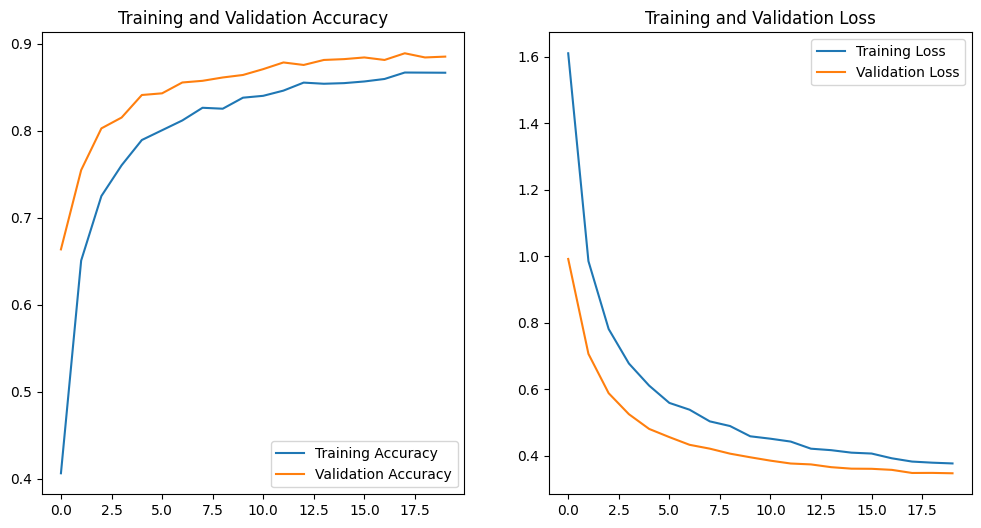

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("\nTest accuracy:", test_acc)

33/33 - 2s - 58ms/step - accuracy: 0.8858 - loss: 0.3421

Test accuracy: 0.8858230113983154


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


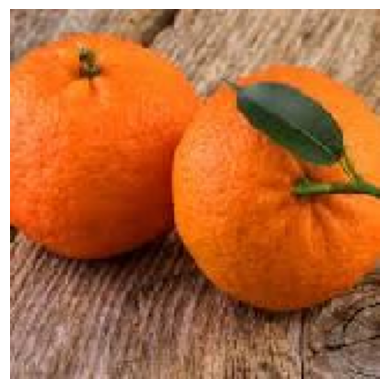

Gambar ini diprediksi sebagai 'BIODEGRADABLE' dengan confidence 99.98%


In [ ]:
# Path gambar baru
img_path = 'jeruk.jpg'

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # batch size 1

# Prediksi
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Menyembunyikan axis
plt.show()

# Tampilkan hasil prediksi dan confidence
predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)
print(f"Gambar ini diprediksi sebagai '{predicted_class}' dengan confidence {confidence:.2f}%")

In [ ]:
# 1.1 Unfreeze base model
base_model.trainable = True

# 1.2 Freeze hanya sebagian awal layer
fine_tune_at = 100  # mulai fine tune dari layer ke-100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Fine tuning mulai dari layer ke-{fine_tune_at} sampai akhir.")

# 1.3 Compile ulang model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# 1.4 Lanjutkan training
fine_tune_epochs = 10  # Tambahan epoch fine tune
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


Fine tuning mulai dari layer ke-100 sampai akhir.
Epoch 20/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - accuracy: 0.7921 - loss: 0.5747 - val_accuracy: 0.8840 - val_loss: 0.3393
Epoch 21/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8482 - loss: 0.4448 - val_accuracy: 0.8926 - val_loss: 0.3278
Epoch 22/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8615 - loss: 0.3965 - val_accuracy: 0.8926 - val_loss: 0.3178
Epoch 23/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.8661 - loss: 0.3654 - val_accuracy: 0.8965 - val_loss: 0.3091
Epoch 24/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8927 - loss: 0.3033 - val_accuracy: 0.8974 - val_loss: 0.2974
Epoch 25/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9000 - loss: 0.2961 - val_accuracy: 0.9051 - val_loss: 0.2794
Epoch 26/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9089 - loss: 0.2672 - val_accuracy: 0.9051 - val_loss: 0.2690
Epoch 27/30
262/262 ━━━━━━━━━━━━━

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("\nTest accuracy:", test_acc)

33/33 - 1s - 32ms/step - accuracy: 0.9049 - loss: 0.2798

Test accuracy: 0.9048525094985962


In [ ]:
# Simpan model
model.save('sortify_ai_v3.h5')
print("Model berhasil disimpan")

Model berhasil disimpan


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━

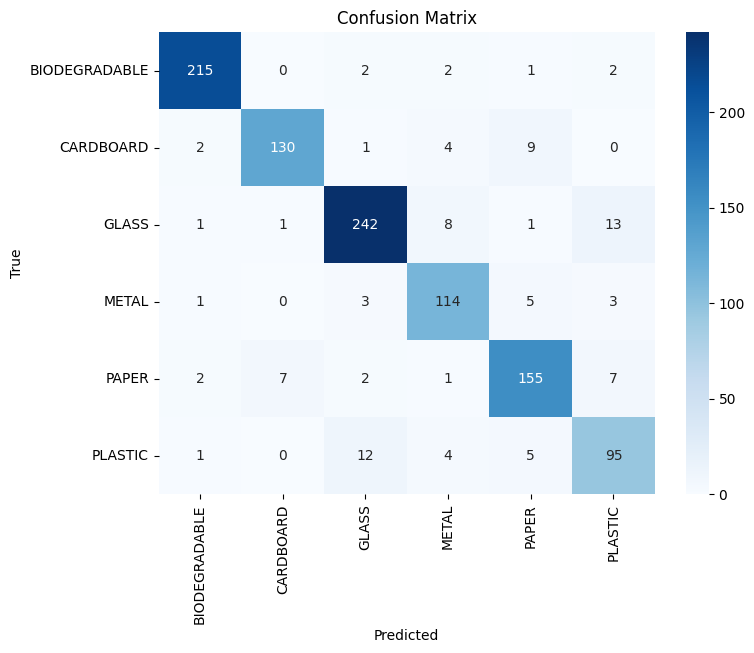

In [ ]:
# Prediksi semua data test
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

# 4.2 Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:\n", cr)

# 4.3 Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()